In [1]:
# Load TikZ extension for drawing
%load_ext jupyter_tikz

# Imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from copy import deepcopy
from qiskit.circuit.library import QuantumVolume

# MLQCP_FM imports
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph, SubGraphManager
from disqco.graphs.coarsening.network_coarsener import NetworkCoarsener
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

from disqco.parti.FM.FM_hetero import run_FM_sparse
from disqco.drawing.tikz_drawing import draw_graph_tikz, draw_subgraph_tikz

print("✅ All imports successful!")
print("✅ TikZ extension loaded!")
print("This notebook will walk through the Network-Coarsened FM algorithm step by step.")

# Problem parameters
num_qubits = 8
num_qpus = 4  # 4-node linear network
qpu_capacity = int(np.ceil(num_qubits / num_qpus)) + 1 
coarsening_factor = 2  # l=2

# Create the quantum circuit (16-qubit Quantum Volume)
from qiskit import transpile
from disqco.circuits.cp_fraction import cp_fraction

# circuit = QuantumVolume(num_qubits, depth=3, seed=42)
circuit = cp_fraction(num_qubits, depth=3, fraction=0.5, seed=42)
# Transpile to the right gate set
circuit = transpile(circuit, basis_gates=['u', 'cp'])


# Create the quantum network (4-node linear topology)
qpu_sizes = [qpu_capacity] * num_qpus  # [4, 4, 4, 4]
connectivity = linear_coupling(num_qpus)  # [(0,1), (1,2), (2,3)]
# connectivity = grid_coupling(num_qpus)  


initial_network = QuantumNetwork(qpu_sizes, connectivity)

network = deepcopy(initial_network)  # Use a copy to avoid modifying the original


# Create the hypergraph representation
hypergraph = QuantumCircuitHyperGraph(circuit)


initial_assignment = np.zeros((hypergraph.depth, hypergraph.num_qubits), dtype=int)


✅ All imports successful!
✅ TikZ extension loaded!
This notebook will walk through the Network-Coarsened FM algorithm step by step.
Number of layers: 5


In [2]:
# # Initialize the network coarsener
# net_coarsener = NetworkCoarsener(network)
# print(f"🔧 Initialized NetworkCoarsener")
# print(f"   Initial network: {net_coarsener.initial_network.num_qpus} QPUs")

# # Perform recursive network coarsening
# print(f"\\n🔄 Starting recursive network coarsening with l={coarsening_factor}")
# start_time = time.time()
# net_coarsener.coarsen_network_recursive(l=coarsening_factor)
# coarsening_time = time.time() - start_time

# print(f"✅ Network coarsening complete in {coarsening_time:.4f} seconds")
# print(f"   Number of coarsening levels: {len(net_coarsener.network_coarse_list)}")

# # Examine the coarsening hierarchy
# print("\\n📊 Network Coarsening Hierarchy:")
# for i, network_level in enumerate(net_coarsener.network_coarse_list):
#     num_nodes = len(network_level.qpu_graph.nodes)
#     qpu_sizes_level = [network_level.qpu_graph.nodes[node]['size'] for node in network_level.qpu_graph.nodes]
#     print(f"   Level {i}: {num_nodes} nodes, sizes {qpu_sizes_level}")

# # Set up the final coarsened network
# final_network = net_coarsener.network_coarse_list[-1]
# final_network.active_nodes = set(final_network.qpu_graph.nodes)

# # Initialize the network level list with the most coarsened network
# network_level_list = []
# network_level_list.append({None: final_network})  # Dict: {source_node: network}
# networks = network_level_list[0]

# print(f"🔧 Starting network cutting process")
# print(f"   Initial level has {len(networks)} sub-networks")

# # Perform network cutting for each coarsening level
# start_time = time.time()
# for i in range(len(net_coarsener.network_coarse_list) - 1):
#     print(f"\n📂 Cutting networks at level {i}")
#     prev_networks = network_level_list[i]
#     print(f"   Input: {len(prev_networks)} networks")
    
#     new_networks = net_coarsener.cut_network(prev_networks, level=i)
#     network_level_list.append(new_networks)
    
#     print(f"   Output: {len(new_networks)} networks")
    
#     # Show details of the new networks
#     for source_node, network in new_networks.items():
#         active_nodes = network.active_nodes
#         node_sizes = [network.qpu_graph.nodes[node]['size'] for node in active_nodes]
#         print(f"     Sub-network {source_node}: {len(active_nodes)} active nodes, sizes {node_sizes}")

# cutting_time = time.time() - start_time
# print(f"\n✅ Network cutting complete in {cutting_time:.4f} seconds")
# print(f"   Total levels created: {len(network_level_list)}")

# # Summary of the network hierarchy
# print("\n📊 Complete Network Hierarchy:")
# for level, networks in enumerate(network_level_list):
#     print(f"   Level {level}: {len(networks)} sub-networks")
#     for source_node, net in networks.items():
#         active_nodes = net.active_nodes
#         sizes = [net.qpu_graph.nodes[node]['size'] for node in active_nodes]
#         print(f"     Sub-net {source_node}: {len(active_nodes)} nodes, sizes {sizes}")

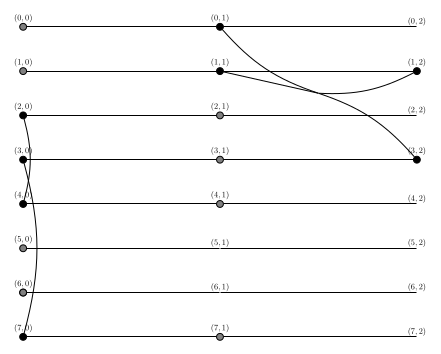

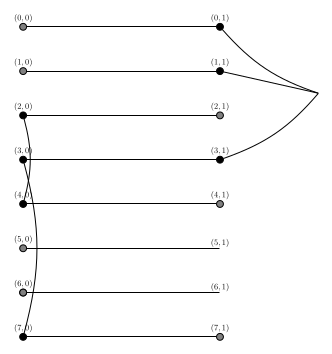

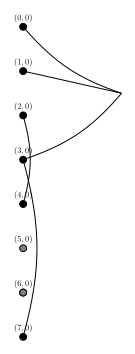

In [3]:
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener
from disqco.drawing.tikz_drawing import draw_graph_tikz, draw_subgraph_tikz

graph_coarsener = HypergraphCoarsener()

graph_list, mapping_list = graph_coarsener.coarsen_recursive_subgraph(hypergraph)

for i, graph in enumerate(graph_list):
    fig = draw_subgraph_tikz(graph, assignment=initial_assignment, qpu_info={0: 20}, node_map={0:0})
    display(fig)

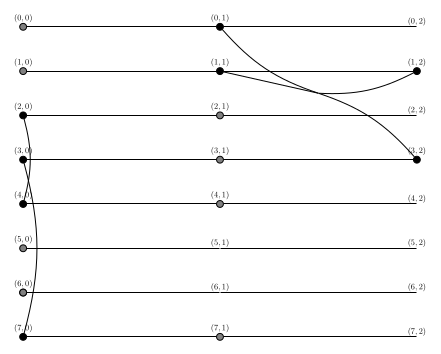

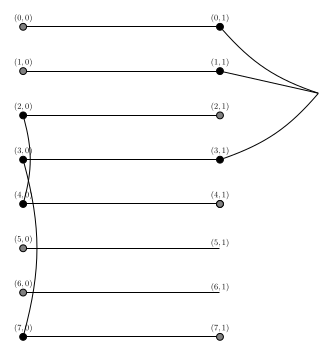

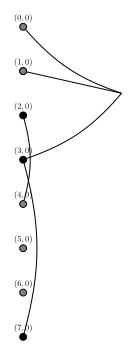

In [4]:
batch_graph_list, batch_mapping_list = graph_coarsener.coarsen_recursive_subgraph_batch(hypergraph)

for i, graph in enumerate(batch_graph_list):
    fig = draw_subgraph_tikz(graph, assignment=initial_assignment, qpu_info={0: 20}, node_map={0:0})
    display(fig)

In [5]:
graph_list = graph_list
batch_graph_list = batch_graph_list

In [6]:

for i, graph in enumerate(graph_list):
    batch_graph = batch_graph_list[i]
    for j, node in enumerate(graph.nodes):
        if node in batch_graph.nodes:
            print(f"Node {node} in Graph {i} is also in Batch graph {i}.")
            node2hyperedges = graph.node2hyperedges[node]
            batch_node2hyperedges = batch_graph.node2hyperedges[node]
            print(f"Node {node} in Graph {i} has hyperedges: {node2hyperedges}")
            print(f"Node {node} in Batch graph {i} has hyperedges: {batch_node2hyperedges}")
            if set(node2hyperedges) == set(batch_node2hyperedges):
                print(f"✅ Node {node} in Graph {i} has equivalent hyperedges in Batch graph {i}.")
            else:
                print(f"❌ Node {node} in Graph {i} has different hyperedges in Batch graph {i}.")
                raise ValueError(f"Node {node} in Graph {i} has different hyperedges in Batch graph {i}.")
            
            for edge in node2hyperedges:
                if edge in batch_node2hyperedges:
                    print(f"Hyperedge {edge} in Graph {i} is also in Batch graph {i}.")
                    edge_info = graph.hyperedges[edge]
                    batch_edge_info = batch_graph.hyperedges[edge]
                    print(f"Hyperedge {edge} in Graph {i} has root set: {edge_info['root_set']}")
                    print(f"Hyperedge {edge} in Batch graph {i} has root set: {batch_edge_info['root_set']}")
                    if set(edge_info['root_set']) == set(batch_edge_info['root_set']):
                        print(f"✅ Hyperedge {edge} in Graph {i} has equivalent root set in Batch graph {i}.")
                    else:
                        print(f"❌ Hyperedge {edge} in Graph {i} has different root set in Batch graph {i}.")
                        raise ValueError(f"Hyperedge {edge} in Graph {i} has different root set in Batch graph {i}.")
                    print(f"Hyperedge {edge} in Graph {i} has receiver set: {edge_info['receiver_set']}")
                    print(f"Hyperedge {edge} in Batch graph {i} has receiver set: {batch_edge_info['receiver_set']}")
                    if set(edge_info['receiver_set']) == set(batch_edge_info['receiver_set']):
                        print(f"✅ Hyperedge {edge} in Graph {i} has equivalent receiver set in Batch graph {i}.")
                    else:
                        print(f"❌ Hyperedge {edge} in Graph {i} has different receiver set in Batch graph {i}.")
                        raise ValueError(f"Hyperedge {edge} in Graph {i} has different receiver set in Batch graph {i}.")
                else:
                    print(f"❌ Hyperedge {edge} in Graph {i} is NOT in Batch graph {i}.")
                    raise ValueError(f"Hyperedge {edge} in Graph {i} is not present in Batch graph {i}.")
            
            adjacency = graph.adjacency[node]
            batch_adjacency = batch_graph.adjacency[node]
            print(f"Node {node} in Graph {i} has adjacency: {adjacency}")
            print(f"Node {node} in Batch graph {i} has adjacency: {batch_adjacency}")
            if set(adjacency) == set(batch_adjacency):
                print(f"✅ Node {node} in Graph {i} has equivalent adjacency in Batch graph {i}.")
            else:
                print(f"❌ Node {node} in Graph {i} has different adjacency in Batch graph {i}.")
                raise ValueError(f"Node {node} in Graph {i} has different adjacency in Batch graph {i}.")
        else:
            print(f"Node {node} in Graph {i} is NOT in Batch graph {i}.")
            raise ValueError(f"Node {node} in Graph {i} is not present in Batch graph {i}.")
    
    # Check if node sets are equivalent
    if set(graph.nodes) == set(batch_graph.nodes):
        print(f"✅ Graph {i} and Batch graph {i} have equivalent node sets.")
    else:
        print(f"❌ Graph {i} and Batch graph {i} have different node sets.")
        raise ValueError(f"Graph {i} and Batch graph {i} have different node sets.")

    print(f"✅✅✅✅ All checks passed! Graphs {i} are equivalent.")

Node (0, 1) in Graph 0 is also in Batch graph 0.
Node (0, 1) in Graph 0 has hyperedges: {((0, 1), (0, 2)), (1, 1), ((0, 0), (0, 1))}
Node (0, 1) in Batch graph 0 has hyperedges: {((0, 1), (0, 2)), (1, 1), ((0, 0), (0, 1))}
✅ Node (0, 1) in Graph 0 has equivalent hyperedges in Batch graph 0.
Hyperedge ((0, 1), (0, 2)) in Graph 0 is also in Batch graph 0.
Hyperedge ((0, 1), (0, 2)) in Graph 0 has root set: {(0, 1)}
Hyperedge ((0, 1), (0, 2)) in Batch graph 0 has root set: {(0, 1)}
✅ Hyperedge ((0, 1), (0, 2)) in Graph 0 has equivalent root set in Batch graph 0.
Hyperedge ((0, 1), (0, 2)) in Graph 0 has receiver set: {(0, 2)}
Hyperedge ((0, 1), (0, 2)) in Batch graph 0 has receiver set: {(0, 2)}
✅ Hyperedge ((0, 1), (0, 2)) in Graph 0 has equivalent receiver set in Batch graph 0.
Hyperedge (1, 1) in Graph 0 is also in Batch graph 0.
Hyperedge (1, 1) in Graph 0 has root set: {(1, 1), (1, 2)}
Hyperedge (1, 1) in Batch graph 0 has root set: {(1, 1), (1, 2)}
✅ Hyperedge (1, 1) in Graph 0 has 

ValueError: Node (0, 1) in Graph 1 has different adjacency in Batch graph 1.